## STP correlation with Tornadoes
##### Dr. Victor Gensini (Spring 2018)
##### Department of Geographic and Atmospheric Sciences
<img style="float:left;height:40px"src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQthtdrc2lZyEOC1iiwubFyvNfzJE7q7_GCTdlFF3peKckmi7cN">

In [1]:
from netCDF4 import date2num,date2index
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy import ndimage
import scipy.stats
import matplotlib.font_manager as font_manager
from matplotlib import cm
from matplotlib.path import Path
import matplotlib.colors as colors
from matplotlib.mlab import bivariate_normal
from matplotlib.colors import LogNorm
from mpl_toolkits.basemap import Basemap, maskoceans
from scipy.stats.mstats import linregress
from scipy import stats
import shapefile
import datetime
#import seaborn as sns
#sns.set()

(31, 277, 349)
(0.2507592462551464, 0.17362431060315939)


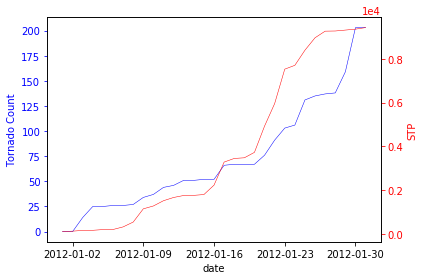

In [2]:
datadir = '/home/data/stp_narr/'
nc1 = Dataset('narr_latlon.nc','r',format='NETCDF4_CLASSIC')
lats = nc1.variables["lats"][0][:][:]
lons = nc1.variables["lons"][0][:][:]
nc1.close()


start_input = '2012010100' #YYYYMMDDHH
end_input  =  '2012013100' #YYYYMMDDHH
######################################
begdate = datetime.datetime.strptime(start_input,"%Y%m%d%H") 
enddate = datetime.datetime.strptime(end_input,"%Y%m%d%H")
dates = []
while begdate <= enddate:
    #print begdate
    dates.append(begdate) #Make a list of the dates to process
    begdate+=datetime.timedelta(hours=24)

raw_counts=[]
tor_days=[]
tor_file = '1950-2016_tor.csv'
tor_df = pd.read_csv(tor_file)
formats = '%Y-%m-%d'
tor_df['datei']=pd.to_datetime(tor_df['date'], format=formats)
tor_df=tor_df.set_index(pd.DatetimeIndex(tor_df['datei']))
raw_counts=[]
tor_days=[]
nc = Dataset('/home/data/stp_narr/stp_cin_1979_2017.nc','r',format='NETCDF4_CLASSIC')
stp_yr = np.empty((0,277,349))


#read shapefile using pyshp (http://code.google.com/p/pyshp/)
sf = shapefile.Reader('/home/vgensini/projects/stp/shapefiles/US_outline.shp')
sfrec = sf.shapeRecord()
points = sfrec.shape.points
#print points
latty_bin = lats.flatten()
lonny_bin = lons.flatten()
lonlat = []

for lt,ln in zip(latty_bin,lonny_bin):
    lonlat.append([ln,lt])
#use points_inside_polygon to 
#clip = matplotlib.nxutils.points_inside_poly(lonlat,points)
path = Path(points)
clip = path.contains_points(lonlat)

#reshape array
clip = clip.reshape(lats.shape)


#stp_dy_val_clip = np.ma.masked_where(clip==False,stp_dy_val)

stp_vals=[]
for dt in dates:
    query='yr>=%s & mo==%s & dy==%s & mag>=0' %(dt.year, dt.month,dt.day)
    torday_df = tor_df.query(query)
    raw_counts.append(torday_df['yr'].count())
    idex = date2index(dt,nc['time'])
    idex1 = date2index(dt+datetime.timedelta(hours=24),nc['time'])
    stp = nc.variables["stp"][idex:idex1][:][:]
    cin  = nc.variables["sbcin"][idex:idex1][:][:]
    #stp = nc.variables["stp"][idex][:][:]
    #cin  = nc.variables["sbcin"][idex][:][:]
    #cin mask
    term5 = np.fabs(cin)
    term5[np.fabs(cin)>25]=0.
    term5[np.fabs(cin)<=25]=1.
    stp = stp * term5
    stp[stp<0]=0.
    stp[stp>=500]=0.
    #stp[stp<1]=0.
    #stp[stp>=1]=1.
    stp=np.max(stp,axis=0)
    stp_vals.append(np.sum(np.ma.masked_where(clip==False,stp)))
    stp_yr = np.append(stp_yr,[stp],axis=0)
print(stp_yr.shape)
fig, ax1 = plt.subplots()
ax1.set_xlabel('date')
ax1.set_ylabel('Tornado Count',color='b')
ax1.tick_params(axis='y', colors='blue')
ax1.plot(dates, np.cumsum(raw_counts), 'b-', linewidth=0.5)
ax2 = ax1.twinx()
ax2.set_ylabel('STP',color='r')
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.tick_params(axis='y', colors='red')
ax2.plot(dates, np.cumsum(stp_vals), 'r-', linewidth=0.5)
plt.tight_layout()
plt.savefig('test.png',dpi=200)
print(scipy.stats.pearsonr(raw_counts,stp_vals))

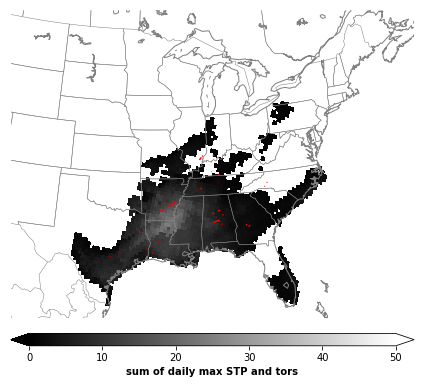

In [3]:
import matplotlib.path as Path
import matplotlib.patches as patches
fig1 = plt.figure()
fig1.set_size_inches(6,6)
ax = fig1.add_subplot(111,frameon=False)
m = Basemap  (projection='lcc',lon_0=-92.54199,lat_0=38.09401,llcrnrlat=24, urcrnrlat=47,llcrnrlon=-106,urcrnrlon=-61,resolution='l',area_thresh=1000)
m.drawcoastlines(color='gray')
m.drawstates(color='gray')
#masked = maskoceans(lons,lats,slope)
#masked = np.ma.masked_where(clip==False,jul_vals)
m.drawcountries(color='gray')
query='yr==2012 & mo>=1 & mo <=1'
torday_df = tor_df.query(query)
tor_lons=torday_df['slon']
tor_lats=torday_df['slat']
tor_lons1=torday_df['elon']
tor_lats1=torday_df['elat']
x,y = m(lons,lats)
x1,y1=m(tor_lons.values,tor_lats.values)
x2,y2=m(tor_lons1.values,tor_lats1.values)
clip_fin = np.ma.masked_where(clip==False,np.sum(stp_yr,axis=0))
clip_fin = np.ma.masked_where(clip_fin<1,clip_fin)
#temper_anom = ['#3c009c','#3609A5','#3013AF','#2A1CB9','#2426C3','#1E30CD','#1839D7','#1243E1','#0C4CEB','#0656F5','#0060FF','#0068FF','#0071FF','#0079FF','#0082FF','#008BFF','#0093FF','#009CFF','#00A4FF','#00ADFF','#00B6FF','#0CBDFF','#18C4FF','#24CBFF','#30D3FF','#3CDAFF','#48E1FF','#54E9FF','#60F0FF','#6CF7FF','#79FFFF','#86FFFF','#93FFFF','#A1FFFF','#AEFFFF','#BCFFFF','#C9FFFF','#D6FFFF','#E4FFFF','#F1FFFF','#FFFFFF','#FFFFFF','#FFFFFF','#FFFEE5','#FFFDCC','#FFFCB2','#FFFB99','#FFFB7F','#FFFA66','#FFF94C','#FFF833','#FFF719','#FFF700','#FFEB00','#FFDF00','#FFD300','#FFC700','#FFBB00','#FFAF00','#FFA300','#FF9700','#FF8B00','#FF7F00','#FE7200','#FE6500','#FE5800','#FE4C00','#FE3F00','#FE3200','#FE2600','#FE1900','#FE0C00','#FE0000','#F50000','#EC0000','#E30000','#DA0000','#D20000','#C90000','#C00000','#B70000','#AE0000','#A60000']
#cmap = matplotlib.colors.ListedColormap(temper_anom)
plot = m.pcolormesh(x,y,clip_fin,vmin=0,vmax=50,zorder=1,cmap=cm.gist_gray)
colbar = m.colorbar(plot,"bottom", size="4%",pad="5%",extend='both')
colbar.set_label('sum of daily max STP and tors',fontsize='medium',weight='bold')

for i,val in enumerate(x1):
    path = matplotlib.path.Path(((x1[i],y1[i]),(x2[i],y2[i])))
    patch=patches.PathPatch(path,edgecolor='red',lw=1.5)
    ax.add_patch(patch)

plt.tight_layout()
plt.savefig('MAM2011.png',dpi=200)